In [6]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
import gzip

In [8]:
! wget http://www.rcsb.org/pdb/files/ss.txt.gz

--2020-10-28 09:03:24--  http://www.rcsb.org/pdb/files/ss.txt.gz
Resolving www.rcsb.org (www.rcsb.org)... 132.249.210.189
Connecting to www.rcsb.org (www.rcsb.org)|132.249.210.189|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz [following]
--2020-10-28 09:03:24--  https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz
Resolving cdn.rcsb.org (cdn.rcsb.org)... 132.249.210.170
Connecting to cdn.rcsb.org (cdn.rcsb.org)|132.249.210.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45712794 (44M) [application/x-gzip]
Saving to: ‘ss.txt.gz’

ss.txt.gz           100%[===================>]  43.59M  63.0MB/s    in 0.7s    

2020-10-28 09:03:25 (63.0 MB/s) - ‘ss.txt.gz’ saved [45712794/45712794]



In [9]:
# Теперь удалим все выбросы: оставим только 20 букв

def check_outlier(s, keys):
    # True — outlier
    res = False
    for key in keys:
        res = res or key in s
    return res

counter = 0
s = []
d = {'idx': [], 'sequence': [], 'secstr': []}
is_outlier = False
with gzip.open('ss.txt.gz', 'rt') as f:
    entity = []
    cur_type = None
    for line in f:
        counter += 1
        if line.startswith('>'):
            if s:
                s = ''.join(s)
                if cur_type == 'sequence':
                    if not check_outlier(s, ['X', 'U', 'Z', 'B', 'O']):
                        d[cur_type] += [s]
                        d['idx'] += ['{}:{}'.format(idx1, idx2)]
                        is_outlier = False
                    else:
                        is_outlier = True
                elif not is_outlier:
                    d[cur_type] += [s]
            s = []
            idx1, idx2, cur_type = line[1:-1].split(':')
        else:
            s += [line.rstrip('\n')]
    if not is_outlier:
        s = ''.join(s)
        d[cur_type] += [s]

counter

4853004

In [10]:
from sklearn.model_selection import train_test_split

seq_train, seq_test, secstr_train, secstr_test = train_test_split(
    d['sequence'], d['secstr'], train_size=0.8, random_state=42)

In [11]:
from torch.utils.data import Dataset, DataLoader

class Protein(Dataset):
    def __init__(self, seq, secstr):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.seq = seq
        self.secstr = secstr

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        return self.seq[idx], self.secstr[idx]

In [12]:
train_data = Protein(seq_train, secstr_train)
train_loader = DataLoader(train_data, batch_size=100, shuffle = True)

test_data = Protein(seq_test, secstr_test)
test_loader = DataLoader(test_data, batch_size=10)

In [13]:
input_char_arr = list('#ACDEFGHIKLMNPQRSTVWY?')
output_char_arr = list('EIBTSHG *?')
input_num_dic = {n: i for i, n in enumerate(input_char_arr)}
output_num_dic = {n: i for i, n in enumerate(output_char_arr)}

In [14]:
import random
import numpy as np
import torch
import torch.nn as nn

from torch import LongTensor as LT

In [15]:
# Seq2Seq Parameter
vocab_size = len(input_num_dic)
n_embed = 25
n_hidden = 128
n_class = len(output_num_dic)

def transform_batch(batch, device='cuda'):
    seq_list, sec_list = batch
    input_batch, output_batch, target_batch = [], [], []
    max_len = 0
    for seq, sec in zip(seq_list, sec_list):
        max_len = max_len if max_len > len(seq) else len(seq)
    max_len = max_len
    for seq, secstr in zip(seq_list, sec_list):
        seq = seq + (max_len - len(seq)) * '?'
        secstr = secstr + (max_len - len(secstr)) * '?'
        input = [input_num_dic[n] for n in seq]
        output = [input_num_dic[n] for n in ('#' + seq)]
        target = [output_num_dic[n] for n in (secstr + '*')]
        input_batch.append(input)
        output_batch.append(output)
        target_batch.append(target)
    return LT(input_batch).to(device), LT(output_batch).to(device), LT(target_batch).to(device)

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, n_class):
        super(Seq2Seq, self).__init__()

        self.enc_lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hidden, bidirectional=True)
        self.dec_lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hidden, bidirectional=True)
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.linear = nn.Linear(2 * n_hidden, n_class)

    def forward(self, enc_input, dec_input):
        enc_input = self.embedding(enc_input).transpose(0, 1) # enc_input: [n_step, batch_size, n_embed]
        dec_input = self.embedding(dec_input).transpose(0, 1) # dec_input: [n_step+1, batch_size, n_embed]
        _, enc_states = self.enc_lstm(enc_input)
        outputs, _ = self.dec_lstm(dec_input, enc_states) # outputs: [n_step+1, batch_size, n_hidden]
        outputs = outputs.transpose(0, 1) # outputs: [batch_size, n_step+1, n_hidden]
        model = self.linear(outputs).transpose(1, 2) # mode: [batch_size, n_class, n_step+1]
        return model

In [17]:
device = 'cuda'

In [18]:
model = Seq2Seq(vocab_size, n_embed, n_hidden, n_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
loss_arr = []
for epoch in range(5):
    print('Epoch:', epoch)
    for itr, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_batch, output_batch, target_batch = transform_batch(batch, device=device)
        output = model(input_batch, output_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        loss_arr += [loss.item()]
        optimizer.step()
        if itr % 100 == 0:
            print('Epoch: {}, iteration: {},'.format(epoch, epoch * len(train_loader) + itr),
                  'loss =', '{:.6f}'.format(loss))

Epoch: 0
Epoch: 0, iteration: 0, loss = 2.367554
Epoch: 0, iteration: 100, loss = 0.313237
Epoch: 0, iteration: 200, loss = 0.370643
Epoch: 0, iteration: 300, loss = 0.309645
Epoch: 0, iteration: 400, loss = 0.150467
Epoch: 0, iteration: 500, loss = 0.384798
Epoch: 0, iteration: 600, loss = 0.324086
Epoch: 0, iteration: 700, loss = 0.281207
Epoch: 0, iteration: 800, loss = 0.262221
Epoch: 0, iteration: 900, loss = 0.412157
Epoch: 0, iteration: 1000, loss = 0.225051
Epoch: 0, iteration: 1100, loss = 0.251763
Epoch: 0, iteration: 1200, loss = 0.292119
Epoch: 0, iteration: 1300, loss = 0.297427
Epoch: 0, iteration: 1400, loss = 0.365830
Epoch: 0, iteration: 1500, loss = 0.393281
Epoch: 0, iteration: 1600, loss = 0.209232
Epoch: 0, iteration: 1700, loss = 0.290658
Epoch: 0, iteration: 1800, loss = 0.324390
Epoch: 0, iteration: 1900, loss = 0.261616
Epoch: 0, iteration: 2000, loss = 0.305857
Epoch: 0, iteration: 2100, loss = 0.316185
Epoch: 0, iteration: 2200, loss = 0.203052
Epoch: 0, iter

In [19]:
model.eval()
with torch.no_grad():
    acc = []
    for idx, batch in enumerate(test_loader):
        if idx % 200 == 0:
            print('{} / {}, mean: {}'.format(idx, len(test_loader), np.mean(acc)))
        seq, secstr = batch
        input_batch, output_batch, target_batch = transform_batch(batch, device=device)
        output = model(input_batch, output_batch)
        predict = output.data.max(1, keepdim=True)[1] # select n_class dimension
        decoded_list = []
        for p in predict:
            decoded = ''.join([output_char_arr[i] for i in p.squeeze()]).rstrip('?*')
            decoded_list += [decoded]
        for y_true, y_pred in zip(secstr, decoded_list):
            try:
                acc += [(np.array(list(y_true)) == np.array(list(y_pred))).mean()]
            except:
                continue
    print(np.mean(acc))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 / 9355, mean: nan
200 / 9355, mean: 0.6409447422206451
400 / 9355, mean: 0.6422135054110176
600 / 9355, mean: 0.6429531193234779
800 / 9355, mean: 0.643203611684103
1000 / 9355, mean: 0.6430893860442451
1200 / 9355, mean: 0.6436262603048046
1400 / 9355, mean: 0.6435942047652803
1600 / 9355, mean: 0.6438632226285625
1800 / 9355, mean: 0.6439113847837145
2000 / 9355, mean: 0.6438414598930744
2200 / 9355, mean: 0.644279690974601
2400 / 9355, mean: 0.6441715034532077
2600 / 9355, mean: 0.6439926156095567
2800 / 9355, mean: 0.6440838769956606
3000 / 9355, mean: 0.6439619418067858
3200 / 9355, mean: 0.6440058632771607
3400 / 9355, mean: 0.6442232615570298
3600 / 9355, mean: 0.6442856644480466
3800 / 9355, mean: 0.6441855815775211
4000 / 9355, mean: 0.6441760720359007
4200 / 9355, mean: 0.6441459879941261
4400 / 9355, mean: 0.6440051575691292
4600 / 9355, mean: 0.6440615689664627
4800 / 9355, mean: 0.6439813376880259
5000 / 9355, mean: 0.6439474355303446
5200 / 9355, mean: 0.643850839151286

In [20]:
[(np.array(list(y_true)) == np.array(list(y_pred))).mean()]

[0.6666666666666666]

In [21]:
import matplotlib.pyplot as plt

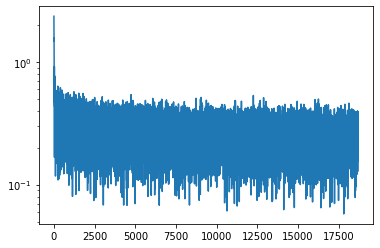

In [22]:
plt.semilogy(loss_arr)
plt.show()

In [25]:
def translate(sequence):
    print(sequence)
    input_batch, output_batch, _ = make_batch(
        {'sequence': [sequence], 'secstr': ['?' * len(sequence)]},
        batch_size=1,
        device=device)
    
    print(output_batch)
    output = model(input_batch, output_batch)
    print(output.shape)
    # output : [max_len+1(=6), batch_size(=1), n_class]
    predict = output.data.max(1, keepdim=True)[1] # select n_class dimension
    decoded = [output_char_arr[i] for i in predict.squeeze()]
    print(len(decoded))
    if '*' in decoded:
        end = decoded.index('*')
        translated = ''.join(decoded[:end])
    else:
        translated = ''.join(decoded)
    return translated.replace('?', ''), 

In [26]:
def translate(sequence, output_sequence=None):
    if output_sequence is None:
        output_sequence = '?' * len(sequence)
    input_batch, output_batch, _ = make_batch(
        {'sequence': [sequence], 'secstr': [output_sequence]},
        batch_size=1,
        device=device)
    
    print(output_batch)
    output = model(input_batch, output_batch)
    print(output.shape)
    predict = output.data.max(1, keepdim=True)[1] # select n_class dimension
    decoded = [output_char_arr[i] for i in predict.squeeze()]
    print(len(decoded))
    if '*' in decoded:
        end = decoded.index('*')
        translated = ''.join(decoded[:end])
    else:
        translated = ''.join(decoded)
    return translated.replace('?', ''), output_sequence

In [27]:
x, y = translate(d['sequence'][0], d['secstr'][0])
(np.array(list(x)) == np.array(list(y))).mean()

NameError: ignored

In [ ]:
{'sequence': [d['sequence'][0]], 'secstr': [d['secstr'][0]]}['sequence'][0]